# **Homework 2 Phoneme Classification**

* Slides: https://docs.google.com/presentation/d/1v6HkBWiJb8WNDcJ9_-2kwVstxUWml87b9CnA16Gdoio/edit?usp=sharing
* Kaggle: https://www.kaggle.com/c/ml2022spring-hw2
* Video: TBA


In [1]:
!nvidia-smi

Wed Mar  9 17:31:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    21W / 170W |   1492MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Git Clone `torchsummay` packages to fix the bugs.

In [ ]:
!git clone https://github.com/Bond-SYSU/pytorch-summary
!mv pytorch-summary/torchsummary ./
!rm pytorch-summary -rf

## Download Data
Download data from google drive, then unzip it.

You should have
- `libriphone/train_split.txt`
- `libriphone/train_labels`
- `libriphone/test_split.txt`
- `libriphone/feat/train/*.pt`: training feature<br>
- `libriphone/feat/test/*.pt`:  testing feature<br>

after running the following block.

> **Notes: if the google drive link is dead, you can download the data directly from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw2/data) and upload it to the workspace**


### Download train/test metadata

In [ ]:
!pip install --upgrade gdown

# Main link
!gdown --id '1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc' --output libriphone.zip

# Backup link 1
# !gdown --id '1R1uQYi4QpX0tBfUWt2mbZcncdBsJkxeW' --output libriphone.zip

# Bqckup link 2
# !wget -O libriphone.zip "https://www.dropbox.com/s/wqww8c5dbrl2ka9/libriphone.zip?dl=1"

!unzip -q libriphone.zip
!ls libriphone

# Import packages

In [2]:
# Numerical Operations
import random
import numpy as np

# Reading/Writing Data
import os
import pandas as pd

# Garbage Collection
import gc

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Ref: https://github.com/Bond-SYSU/pytorch-summary
from torchsummary import summary

# Visualize the training information
import matplotlib.pyplot as plt

# For hyper-parameters searching
import optuna

# Utility Functions

In [3]:
def same_seed(seed): 
    """ Fixes random number generator seeds for reproducibility. """
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Preparing Data

**Helper functions to pre-process the training data from raw MFCC features of each utterance.**

A phoneme may span several frames and is dependent to past and future frames. \
Hence we concatenate neighboring phonemes for training to achieve higher accuracy. The **concat_feat** function concatenates past and future k frames (total 2k+1 = n frames), and we predict the center frame.

Feel free to modify the data preprocess functions, but **do not drop any frame** (if you modify the functions, remember to check that the number of frames are the same as mentioned in the slides)

In [4]:
def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x, n):
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x, concat_n):
    """ Get n frames' features. """
    assert concat_n % 2 == 1                # Total n frames must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size()         # Dimension: (seq_len, feature_dim)
    x = x.repeat(1, concat_n)               # Repeats tensor x along the specified dimensions.
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # Dimension: (concat_n, seq_len, feature_dim)
    mid = (concat_n // 2)                   # Get the middle of n frames(We want to predict).
    for r_idx in range(1, mid+1):
        x[mid + r_idx] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2)               # Dimension: (seq_len, concat_n, feature_dim)

def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, train_val_seed=1337):
    class_num = 41                          # NOTE: pre-computed, should not need change
    mode = 'train' if (split == 'train' or split == 'valid') else 'test'

    # Get train / valid label dictionary
    label_dict = {}
    if mode != 'test':
        phone_file = open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines()

        for line in phone_file:
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]

    if split == 'train' or split == 'valid':
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(train_val_seed)                         # Fix the random seed.
        random.shuffle(usage_list)                          # Training data shuffled.
        percent = int(len(usage_list) * train_ratio)        # Border index between training and validation data.
        usage_list = usage_list[:percent] if split == 'train' else usage_list[percent:] # Get training / validation data
    elif split == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    usage_list = [line.strip('\n') for line in usage_list]  # Strip newline in dataset.
    print(f"[Dataset] - # phone classes: {str(class_num)}, number of utterances for {split}: {str(len(usage_list))}")

    max_len = 3000000
    X = torch.empty(max_len, concat_nframes, 39)            # Create an empty tensor.
    if mode != 'test':
        y = torch.empty(max_len, dtype=torch.long)          # Create an empty tensor.

    idx = 0
    for fname in tqdm(usage_list):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))       # Load features.
        cur_len = len(feat)                                                 # Length of features
        feat = concat_feat(feat, concat_nframes)                            # Get features after concatenating n frames.
        # Get train / valid labels.
        if mode != 'test':
            label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat                                     # Copy features to X.
        if mode != 'test':
            y[idx: idx + cur_len] = label                                   # Copy label to y.

        idx += cur_len

    X = X[:idx, :]      # Discard other empty tensor.
    if mode != 'test':
        y = y[:idx]     # Discard other empty tensor.

    print(f"[INFO] {split} set")
    print(X.shape)
    if mode != 'test':
        print(y.shape)
        return X, y
    else:
        return X


## Define Dataset

In [5]:
class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


## Define Model

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim, prob=0.2):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(output_dim),
            nn.Dropout(p=prob),
        )

    def forward(self, x):
        x = self.block(x)
        return x


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256, num_layers=3, prob=0.3, device='cuda'):
        super(LSTMClassifier, self).__init__()
        self.num_layers = hidden_layers
        self.hidden_size = hidden_dim
        self.device = device
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=prob,
            batch_first=True,
            bidirectional=True,
        )

        self.fc = nn.Sequential(
            *[BasicBlock(int(hidden_dim / pow(2, i)), int(hidden_dim / pow(2, i+1)), prob) for i in range(hidden_layers)],
            nn.Linear(int(hidden_dim / pow(2, hidden_layers)), output_dim)
        )

    def forward(self, x):
        # h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # hidden state
        # c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # internal state
        output, (h_n, c_n) = self.lstm(x)   # Propagate to LSTM getting output, hidden state and internal state
        h_n = self.fc(h_n[-1])              # Use the hidden state of output in last layer of LSTM.
        return h_n

# Configurations
Define own parameters for the whole architecture.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

concat_nframes = 51             # Number of frames to concat with, n must be odd (total 2k+1 = n frames)

config = {
    # Data Processing parameters.
    'train_ratio': 0.95,        # training_size = train_size * train_ratio(The rest are validation)

    # Training parameters.
    'seed': 5201314,            # Your seed number, you can pick your lucky number. :)
    'n_epochs': 20,             # Number of epochs
    'batch_size': 256,          # Batch size
    'optimizer': 'AdamW',       # Select optimizer
    'optim_hparas': {           # Hyper-parameters of optimizer
        'lr': 0.001,            # Learning rate for optimizer
        'weight_decay': 0.1     # L2 Regularization
    },
    
    # Learning Rate Scheduler
    'lr_scheduler': 'CosineAnnealingLR',
    'lr_hparas': {              # Hyper-parameters of Learning Rate Scheduler
        'T_max': 5,
        'verbose': True
    },
    
    'save_path': './models/modelLSTM.ckpt',  # Your model will be saved here.

    # Model parameters.
    'model_paras': {
        'input_dim': 39,        # Input dimension of the model(Varies with concat frames)
        'hidden_layers': 2,     # Number of hidden layers
        'hidden_dim': 256,      # Each hidden layer's dimension
        'num_layers': 5,        # Number of LSTM layers
        'prob': 0.5,            # Dropout probability
        'device': device
    }
}

Using cuda device


# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [8]:
# Preprocess data
train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=config['train_ratio'])
valid_X, valid_y = preprocess_data(split='valid', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=config['train_ratio'])

# Get dataset
train_set = LibriDataset(train_X, train_y)
valid_set = LibriDataset(valid_X, valid_y)

# Remove raw feature to save memory
del train_X, train_y, valid_X, valid_y
gc.collect()

# Get dataloader
train_loader = DataLoader(train_set, batch_size=config['batch_size'], num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], num_workers=2, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for train: 4071


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4071/4071 [00:34<00:00, 117.39it/s]


[INFO] train set
torch.Size([2513163, 51, 39])
torch.Size([2513163])
[Dataset] - # phone classes: 41, number of utterances for valid: 215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:01<00:00, 117.08it/s]

[INFO] valid set
torch.Size([130995, 51, 39])
torch.Size([130995])


## Training Loop

In [9]:
def trainer(train_loader, valid_loader, model, config, device, param=None, trial=None):

    criterion = nn.CrossEntropyLoss()           # Define the loss function.

    # If we sepcify parameters for selection of optimizer, otherwise use optimizer in config.
    if param:
        optimizer = getattr(torch.optim, param['optimizer'])(model.parameters(), **param['optim_hparas'])
    else:
        optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
        
    # Learning rate scheduling
    if hasattr(torch.optim.lr_scheduler, config['lr_scheduler']):
        scheduler = getattr(torch.optim.lr_scheduler, config['lr_scheduler'])(optimizer, **config['lr_hparas'])
    else:
        scheduler = None

    if not os.path.isdir('./models'):
        os.mkdir('./models')                    # Create directory of saving models.

    n_epochs, best_acc = config['n_epochs'], 0.0
    train_acc_record, train_loss_record = [], []
    valid_acc_record, valid_loss_record = [], []


    for epoch in range(n_epochs):
        train_acc, train_loss = 0.0, 0.0
        valid_acc, valid_loss = 0.0, 0.0

        """Training"""
        size = len(train_loader.dataset)        # Number of training data.
        batch_size = len(train_loader)          # Number of batches.

        model.train()                           # Set your model to training mode.

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for X, y in train_pbar:
            X, y = X.to(device), y.to(device)   # Move the dataset to the device('cpu'/'cuda') that torch assign.

            # Compute prediction error
            pred = model(X) 
            loss = criterion(pred, y)

            # Backpropagation
            optimizer.zero_grad()               # Set gradient to zero.
            loss.backward()                     # Compute gradient(backpropagate).
            optimizer.step()                    # Update parameters.

            # Get the index of the class with the highest probability
            train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f"Train")

        # Compute the average loss among all batches and the accuracy of an epoch.
        train_acc_record.append(train_acc / size)
        train_loss_record.append(train_loss / batch_size)

        """Validation"""
        if len(valid_loader.dataset) > 0:       # No data in validation dataloader.
            size = len(valid_loader.dataset)    # Number of validation data.
            batch_size = len(valid_loader)      # Number of batches.

            model.eval()                        # Set your model to evaluation mode.

            # tqdm is a package to visualize your validation progress.
            valid_pbar = tqdm(valid_loader, position=0, leave=True)

            with torch.no_grad():
                for X, y in valid_pbar:
                    X, y = X.to(device), y.to(device)   # Move the dataset to the device('cpu'/'cuda') that torch assign.

                    # Compute prediction error
                    pred = model(X) 
                    loss = criterion(pred, y)

                    valid_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
                    valid_loss += loss.item()

                    # Display current epoch number and loss on tqdm progress bar.
                    valid_pbar.set_description(f"Valid")

                # Compute the average loss among all batches and the accuracy of an epoch
                valid_acc_record.append(valid_acc / size)
                valid_loss_record.append(valid_loss / batch_size)

            print(f"Epoch: {epoch+1:>3d} / {n_epochs:>3d}")
            print(f"\tTraining   Acc: {train_acc_record[-1]:>7f} | loss: {train_loss_record[-1]:>7f}")
            print(f"\tValidation Acc: {valid_acc_record[-1]:>7f} | loss: {valid_loss_record[-1]:>7f}")

            # Updates the current best acc and save the best model
            if valid_acc_record[-1] > best_acc:
                best_acc = valid_acc_record[-1]
                torch.save(model.state_dict(), config['save_path'])
                print(f"Saving model with acc {best_acc:0.3f}")
                
            if scheduler:                       # Use Learning Rate Scheduler
                scheduler.step()
        else:
            print(f"Epoch: {epoch+1:>3d} / {n_epochs:>3d}")
            print(f"\tTraining Acc: {train_acc[-1]:>7f} | loss: {train_loss[-1]:>7f}")

    # If not validation, save the last epoch
    if len(valid_loader.dataset) == 0:
        torch.save(model.state_dict(), config['save_path'])
        print('Saving model at last epoch')

    return train_acc_record, train_loss_record, valid_acc_record, valid_loss_record # Return the information about training & validation


# Start training!

In [10]:
# Set seed for reproducibility
same_seed(config['seed'])

In [11]:
model = LSTMClassifier(**config['model_paras']).to(device)      # Put the model and data on the same computation device.

# Get the input size of training data.
input_size = None
for X, y in train_loader:
    input_size = X.shape[1:]                                    # input_size = (C, H, W)
    break

# Pass model and the input size as parameters.
print(model)
summary(model, input_size)

LSTMClassifier(
  (lstm): LSTM(39, 256, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (1): BasicBlock(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (2): Linear(in_features=64, out_features=41, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1  [[-1, 51, 512], [[10, -1, 256], [10, -1, 2

In [12]:
train_acc, train_loss, valid_acc, valid_loss = trainer(train_loader, valid_loader, model, config, device)

Adjusting learning rate of group 0 to 1.0000e-03.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.39it/s]


Epoch:   1 /  20
	Training   Acc: 0.613654 | loss: 1.411458
	Validation Acc: 0.755830 | loss: 0.863238
Saving model with acc 0.756
Adjusting learning rate of group 0 to 9.0451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.97it/s]


Epoch:   2 /  20
	Training   Acc: 0.779677 | loss: 0.828883
	Validation Acc: 0.790389 | loss: 0.756297
Saving model with acc 0.790
Adjusting learning rate of group 0 to 6.5451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.30it/s]


Epoch:   3 /  20
	Training   Acc: 0.826582 | loss: 0.649360
	Validation Acc: 0.807428 | loss: 0.730772
Saving model with acc 0.807
Adjusting learning rate of group 0 to 3.4549e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.78it/s]


Epoch:   4 /  20
	Training   Acc: 0.866282 | loss: 0.489429
	Validation Acc: 0.827887 | loss: 0.685771
Saving model with acc 0.828
Adjusting learning rate of group 0 to 9.5492e-05.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.95it/s]


Epoch:   5 /  20
	Training   Acc: 0.900720 | loss: 0.353229
	Validation Acc: 0.838414 | loss: 0.703346
Saving model with acc 0.838
Adjusting learning rate of group 0 to 0.0000e+00.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.87it/s]


Epoch:   6 /  20
	Training   Acc: 0.909908 | loss: 0.315798
	Validation Acc: 0.838742 | loss: 0.702994
Saving model with acc 0.839
Adjusting learning rate of group 0 to 9.5492e-05.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.95it/s]


Epoch:   7 /  20
	Training   Acc: 0.910134 | loss: 0.312978
	Validation Acc: 0.837192 | loss: 0.728249
Adjusting learning rate of group 0 to 3.4549e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.89it/s]


Epoch:   8 /  20
	Training   Acc: 0.880119 | loss: 0.428260
	Validation Acc: 0.822047 | loss: 0.719087
Adjusting learning rate of group 0 to 6.5451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.37it/s]


Epoch:   9 /  20
	Training   Acc: 0.844412 | loss: 0.570620
	Validation Acc: 0.811359 | loss: 0.716336
Adjusting learning rate of group 0 to 9.0451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.54it/s]


Epoch:  10 /  20
	Training   Acc: 0.823573 | loss: 0.654297
	Validation Acc: 0.805825 | loss: 0.722975
Adjusting learning rate of group 0 to 1.0000e-03.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.69it/s]


Epoch:  11 /  20
	Training   Acc: 0.823688 | loss: 0.653062
	Validation Acc: 0.806641 | loss: 0.716947
Adjusting learning rate of group 0 to 9.0451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.11it/s]


Epoch:  12 /  20
	Training   Acc: 0.831097 | loss: 0.624229
	Validation Acc: 0.809985 | loss: 0.709838
Adjusting learning rate of group 0 to 6.5451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.56it/s]


Epoch:  13 /  20
	Training   Acc: 0.856223 | loss: 0.522761
	Validation Acc: 0.816642 | loss: 0.714426
Adjusting learning rate of group 0 to 3.4549e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.89it/s]


Epoch:  14 /  20
	Training   Acc: 0.890233 | loss: 0.386461
	Validation Acc: 0.834200 | loss: 0.696203
Adjusting learning rate of group 0 to 9.5492e-05.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.07it/s]


Epoch:  15 /  20
	Training   Acc: 0.919552 | loss: 0.273785
	Validation Acc: 0.848551 | loss: 0.707304
Saving model with acc 0.849
Adjusting learning rate of group 0 to 0.0000e+00.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 19.83it/s]


Epoch:  16 /  20
	Training   Acc: 0.927097 | loss: 0.244127
	Validation Acc: 0.848697 | loss: 0.710587
Saving model with acc 0.849
Adjusting learning rate of group 0 to 9.5492e-05.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:35<00:00, 14.34it/s]


Epoch:  17 /  20
	Training   Acc: 0.926702 | loss: 0.244335
	Validation Acc: 0.846330 | loss: 0.750472
Adjusting learning rate of group 0 to 3.4549e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.48it/s]


Epoch:  18 /  20
	Training   Acc: 0.896877 | loss: 0.358248
	Validation Acc: 0.829383 | loss: 0.729060
Adjusting learning rate of group 0 to 6.5451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:24<00:00, 20.96it/s]


Epoch:  19 /  20
	Training   Acc: 0.854642 | loss: 0.526702
	Validation Acc: 0.820321 | loss: 0.702851
Adjusting learning rate of group 0 to 9.0451e-04.


Valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:25<00:00, 20.17it/s]

Epoch:  20 /  20
	Training   Acc: 0.834263 | loss: 0.608924
	Validation Acc: 0.814481 | loss: 0.715519
Adjusting learning rate of group 0 to 1.0000e-03.


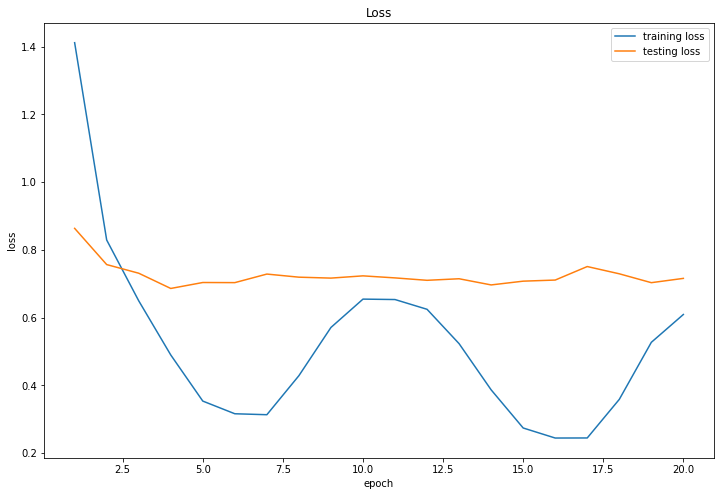

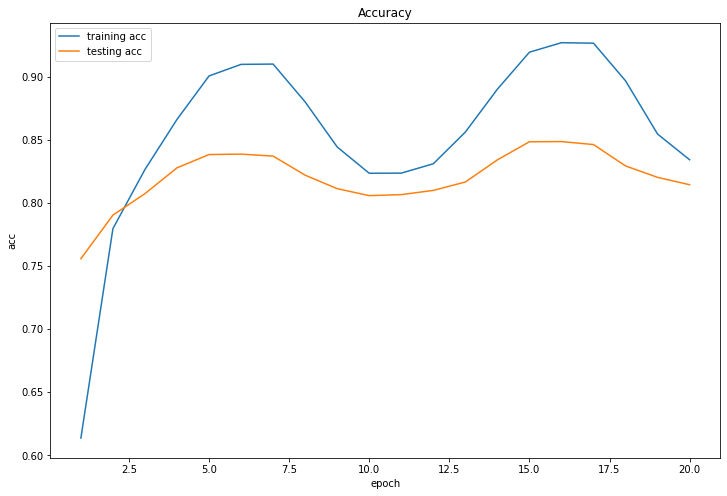

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, config['n_epochs'] + 1)), train_loss)   # plot your training loss
plt.plot(list(range(1, config['n_epochs'] + 1)), valid_loss)   # plot your validation loss
plt.title('Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['training loss', 'testing loss'], loc = 'upper right')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(list(range(1, config['n_epochs'] + 1)), train_acc)    # plot your training accuracy
plt.plot(list(range(1, config['n_epochs'] + 1)), valid_acc)    # plot your validation accuracy
plt.title('Accuracy')
plt.ylabel('acc'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig('acc.png')
plt.show()

In [14]:
del train_loader, valid_loader
gc.collect()

7042

## Testing
Create a testing dataset, and load model from the saved checkpoint.

In [15]:
# load data
test_X = preprocess_data(split='test', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes)
test_set = LibriDataset(test_X, None)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for test: 1078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1078/1078 [00:24<00:00, 44.38it/s]

[INFO] test set
torch.Size([646268, 51, 39])


In [16]:
# load model
model = LSTMClassifier(**config['model_paras']).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

# Prediction

In [17]:
test_acc = 0.0
test_lengths = 0
preds = np.array([], dtype=np.int32)

model.eval()                        # Set your model to evaluation mode.
with torch.no_grad():               # In evaluation mode, no need gradient
    for X in tqdm(test_loader):
        X = X.to(device)            # Move the dataset to the device('cpu'/'cuda') that torch assign.

        pred = model(X)             # Predictions.

        pred = pred.argmax(axis=1)  # Get the index of maximum prediction values.
        preds = np.concatenate((preds, pred.cpu().numpy()), axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2525/2525 [02:01<00:00, 20.84it/s]


Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [18]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(preds):
        f.write('{},{}\n'.format(i, y))

# Optuna Hyper-paramters Search (optional)
Define the objective function and find the best parameters for given range of parameters.

In [ ]:
def objective(trial):
    """ Objective function """
    # Parameters will search
    params = {
        'n_frames': trial.suggest_int("n_frames", 1, 51, 2),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024]),
         
        # Model parameters.
        'model_paras': {
            'input_dim': 39,        # Input dimension of the model(Varies with concat frames)
            'hidden_layers': trial.suggest_int("hidden_layers", 1, 3, 1),
            'hidden_dim': trial.suggest_categorical('hidden_dim', [128, 256, 512, 1024]),
            'num_layers': trial.suggest_int("num_layers", 1, 6, 1),
            'prob': trial.suggest_categorical('prob', [0.2, 0.3, 0.5, 0.7, 0.8]),
            'device': device
        }
    }
    
    config = {
        # Data Processing parameters.
        'train_ratio': 0.95,        # training_size = train_size * train_ratio(The rest are validation)

        # Training parameters.
        'seed': 5201314,            # Your seed number, you can pick your lucky number. :)
        'n_epochs': 20,             # Number of epochs
        'batch_size': 256,          # Batch size
        'optimizer': 'AdamW',       # Select optimizer
        'optim_hparas': {           # Hyper-parameters of optimizer
            'lr': 0.001,            # Learning rate for optimizer
            'weight_decay': 0.1     # L2 Regularization
        },
        
        # Learning Rate Scheduler
        'lr_scheduler': 'CosineAnnealingLR',
        'lr_hparas': {              # Hyper-parameters of Learning Rate Scheduler
            'T_max': 5,
            'verbose': True
        },
        
        'save_path': './models/modelOptuna.ckpt',  # Your model will be saved here.

        # Model parameters.
        'model_paras': {
            'input_dim': 39,        # Input dimension of the model(Varies with concat frames)
            'hidden_layers': 2,     # Number of hidden layers
            'hidden_dim': 256,      # Each hidden layer's dimension
            'num_layers': 5,        # Number of LSTM layers
            'prob': 0.5,            # Dropout probability
            'device': device
        }
    }

    # Preprocess data
    train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=43, train_ratio=config['train_ratio'])
    valid_X, valid_y = preprocess_data(split='valid', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=43, train_ratio=config['train_ratio'])

    # Get dataset
    train_set = LibriDataset(train_X, train_y)
    valid_set = LibriDataset(valid_X, valid_y)

    # Remove raw feature to save memory
    del train_X, train_y, valid_X, valid_y
    gc.collect()

    # Get dataloader
    train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=params['batch_size'], shuffle=False)
    
    same_seed(config['seed'])

    model = LSTMClassifier(**params['model_paras']).to(device)  # Specify the activation and n_units
    train_acc, train_loss, valid_acc, valid_loss = trainer(train_loader, valid_loader, model, config, device)   # Get the best acc / loss of validation
    return max(valid_acc)                                       # Return maximum accuracy of validation

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())   # Maximize the objective accuracy
study.optimize(objective, n_trials=25)                                                                                          # Do n_trails

In [ ]:
best_trial = study.best_trial               # The best trial's parameters

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
for trial in study.trials:                  # Total trials
    print(f"Params: {trial.params}, Acc: {trial.values[0]}")